## Activations

In [74]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy
from collections import deque

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * ya


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x)) #softmax

In [3]:
class LSTM_Param:
    def __init__(self, value):
        self.value = value
        self.deriv = np.zeros_like(value) #derivative
        self.momentum = np.zeros_like(value) #momentum for AdaGrad
        
    def clear_gradient(self):
        self.deriv = np.zeros_like(self.value) #derivative
        
    def clip_gradient(self):
        self.deriv = np.clip(self.deriv, -1, 1, out=self.deriv)
        
    def update(self, learning_rate):
        self.momentum += self.deriv * self.deriv # Calculate sum of gradients
        self.value += -(learning_rate * self.deriv / np.sqrt(self.momentum + 1e-8))
        
    def update_sgd(self, learning_rate):
        self.value -= learning_rate * self.deriv

In [115]:
class LSTM_Params:
    
    def __init__(self, hidden_size, vocab_size):
        self.stack_size = hidden_size + vocab_size
        
        self.W_f = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_i = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_c = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_o = LSTM_Param(np.random.normal(size=(self.stack_size, hidden_size), loc=0, scale=0.1))
        self.W_v = LSTM_Param(np.random.normal(size=(hidden_size, vocab_size), loc=0, scale=0.1))
        
        self.B_f = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_i = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_c = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_o = LSTM_Param(np.zeros((1, hidden_size)))
        self.B_v = LSTM_Param(np.zeros((1, vocab_size)))

        
    def all_params(self):
        return [self.W_f, self.W_i, self.W_c, self.W_o, self.W_v, 
                self.B_f, self.B_i, self.B_c, self.B_o, self.B_v]
        
    def clear_gradients(self):
        for param in self.all_params():
            param.clear_gradient()
        
    def clip_gradients(self):
        for param in self.all_params():
            param.clip_gradient()       
       
    def update_params(self, learning_rate, method="ada"):
        for param in self.all_params():
            if method == "ada":
                param.update(learning_rate)  
            elif method == "sgd":
                param.update_sgd(learning_rate)

In [146]:
class LSTM_Node:
    '''
    An LSTM Node that takes in input and generates output. 
    Has a size of its hidden layers and a vocabulary size it expects.
    '''
    def __init__(self, hidden_size, vocab_size):
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

    def forward(self, x, h_prev, C_prev, LSTM_Params):

        self.C_prev = C_prev

        self.z = np.column_stack((x, h_prev))
        
        self.f = sigmoid(np.dot(self.z, LSTM_Params.W_f.value) + LSTM_Params.B_f.value)
        self.i = sigmoid(np.dot(self.z, LSTM_Params.W_i.value) + LSTM_Params.B_i.value)
        self.C_bar = tanh(np.dot(self.z, LSTM_Params.W_c.value) + LSTM_Params.B_c.value)

        self.C = self.f * C_prev + self.i * self.C_bar
        self.o = sigmoid(np.dot(self.z, LSTM_Params.W_o.value) + LSTM_Params.B_o.value)
        self.H = self.o * tanh(self.C)

        self.v = np.dot(self.H, LSTM_Params.W_v.value) + LSTM_Params.B_v.value
        self.y = np.exp(self.v) / np.sum(np.exp(self.v))
        
        return self.y, self.H, self.C 


    def backward(self, loss_grad, dh_next, dC_next, LSTM_Params):

        assert self.z.shape == (1, self.vocab_size + self.hidden_size)
        assert self.v.shape == (1, self.vocab_size)
        assert self.y.shape == (1, self.vocab_size)
    
#         for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
#             assert param.shape == (1, self.hidden_size)


        LSTM_Params.W_v.deriv += np.dot(self.H.T, loss_grad)
        LSTM_Params.B_v.deriv += loss_grad

        dh = np.dot(loss_grad, LSTM_Params.W_v.value.T)        
        dh += dh_next
        do = dh * tanh(self.C)
        do_int = dsigmoid(self.o) * do
        LSTM_Params.W_o.deriv += np.dot(self.z.T, do_int)
        LSTM_Params.B_o.deriv += do_int

        dC = np.copy(dC_next)
        dC += dh * self.o * dtanh(tanh(self.C))
        dC_bar = dC * self.i
        dC_bar_int = dtanh(self.C_bar) * dC_bar
        LSTM_Params.W_c.deriv += np.dot(self.z.T, dC_bar_int)
        LSTM_Params.B_c.deriv += dC_bar_int

        di = dC * self.C_bar
        di_int = dsigmoid(self.i) * di
        LSTM_Params.W_i.deriv += np.dot(self.z.T, di_int)
        LSTM_Params.B_i.deriv += di_int

        df = dC * self.C_prev
        df_int = dsigmoid(self.f) * df
        LSTM_Params.W_f.deriv += np.dot(self.z.T, df_int)
        LSTM_Params.B_f.deriv += df_int

        dz = (np.dot(df_int, LSTM_Params.W_f.value.T)
             + np.dot(di_int, LSTM_Params.W_i.value.T)
             + np.dot(dC_bar_int, LSTM_Params.W_c.value.T)
             + np.dot(do_int, LSTM_Params.W_o.value.T))
        dx_prev = dz[:, :self.vocab_size]
        dH_prev = dz[:, self.vocab_size:]
        dC_prev = self.f * dC
        
        return dx_prev, dH_prev, dC_prev

In [151]:
class LSTM_Layer:
    def __init__(self, sequence_length, vocab_size, hidden_size, learning_rate):
        self.nodes = [LSTM_Node(hidden_size, vocab_size) for x in range(sequence_length)]
        self.sequence_length = sequence_length
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.params = LSTM_Params(hidden_size, vocab_size)

    
    def forward(self, x_batch_in):
        
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        num_chars = x_batch_in.shape[0]
        
        x_batch_out = np.zeros((num_chars, self.vocab_size))
        
        for t in range(num_chars):
            x_in = np.array(x_batch_in[t, :], ndmin=2)
            
            y_out, H_in, C_in = self.nodes[t].forward(x_in, H_in, C_in, self.params)
      
            x_batch_out[t, :] = y_out
    
        self.start_H = H_in
        self.start_C = C_in

        return x_batch_out


    def backward(self, loss_grad):
        dh_next = np.zeros_like(self.start_H) #dh from the next character
        dC_next = np.zeros_like(self.start_C) #dc from the next character
        
        num_chars = loss_grad.shape[0]
        
        loss_grad_out = np.zeros((num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            loss_grad_in = np.array(loss_grad[t, :], ndmin=2)
            # Backward pass
            grad_out, dh_next, dC_next = \
                self.nodes[t].backward(loss_grad_in, dh_next, dC_next, self.params)
        
            loss_grad_out[t, :] = grad_out
        
        return loss_grad_out

In [155]:
class LSTM_Model:
    '''
    An LSTM model with one LSTM layer that feeds data through it and generates an output.
    '''
    def __init__(self, layers, sequence_length, vocab_size, hidden_size, learning_rate):
        '''
        Initialize list of nodes of length the sequence length
        List the vocab size and the hidden size 
        Initialize the params
        '''
        self.num_layers = layers
        self.layers = [LSTM_Layer(sequence_length, vocab_size, hidden_size, learning_rate) for i in range(self.num_layers)]
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate

        
    def forward(self, inputs):
        
        num_chars = len(inputs)
        
        x_batch_in = np.zeros((num_chars, self.vocab_size))
        for t in range(num_chars):
            x_batch_in[t, inputs[t]] = 1 # Input character
        
        for layer in self.layers:
#             print("Forward through Layer", i)
            x_batch_in = layer.forward(x_batch_in)
                
        return x_batch_in

    def loss(self, x_batch_out, inputs, targets):
        '''
        MSE loss
        '''
        y_batch = np.zeros((len(inputs), self.vocab_size))
        for t in range(len(inputs)):
            y_batch[t, targets[t]] = 1
        loss = np.sum((x_batch_out - y_batch) ** 2)

        return loss
    
    
    def loss_gradient(self, x_batch_out, inputs, targets):
        '''
        MSE loss
        '''
        y_batch = np.zeros((len(inputs), self.vocab_size))
        for t in range(len(inputs)):
            y_batch[t, targets[t]] = 1
        return -1.0 * (y_batch - x_batch_out)
    


    def backward(self, loss_grad):
        
        num_chars = loss_grad.shape[0]
        
        for layer in reversed(self.layers):
            # Backward pass
            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, inputs, targets):
        x_batch_out = self.forward(inputs)
        
        loss = self.loss(x_batch_out, inputs, targets)
        
        loss_grad = self.loss_gradient(x_batch_out, inputs, targets)
        
        for layer in self.layers:
            layer.params.clear_gradients()
        
        self.backward(loss_grad)

        for layer in self.layers:
            layer.params.clip_gradients()  
            layer.params.update_params(layer.learning_rate)
            
        
        return loss

In [159]:
class Character_generator:
    def __init__(self, text_file, LSTM_Model):
        self.data = open(text_file, 'r').read()
        self.model = LSTM_Model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.iterations = 0
        self.start_pos = 0
        self.sequence_length = self.model.sequence_length
    
    def _generate_inputs_targets(self, start_pos):
        inputs = ([self.char_to_idx[ch] 
                   for ch in self.data[start_pos: start_pos + self.sequence_length]])
        targets = ([self.char_to_idx[ch] 
                    for ch in self.data[start_pos + 1: start_pos + self.sequence_length + 1]])
        return inputs, targets


    def sample_output(self, input_char, sample_length):
        
        indices = []
        
        sample_model = deepcopy(self.model)
        
        for i in range(sample_length):
            x_batch_out = sample_model.forward([input_char])
        
            input_char = np.random.choice(range(self.vocab_size), p=x_batch_out.ravel())
            
            indices.append(input_char)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt
    
    
    def single_step(self):
   
        inputs, targets = self._generate_inputs_targets(self.start_pos)
        
        loss = self.model.single_step(inputs, targets)
        
        return loss


    def training_loop(self, num_iterations):
        
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        
        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:
            
            if self.start_pos + self.sequence_length > len(self.data):
                self.start_pos = 0
            
            ## Update the model
            loss = self.single_step()
            ##
            
            moving_average.append(loss)
            ma_loss = np.mean(moving_average)
            
            self.start_pos += self.sequence_length
            
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[self.start_pos]], 
                                                 200)
                print(sample_text)

            self.start_pos += self.sequence_length
            num_iter += 1
            
            

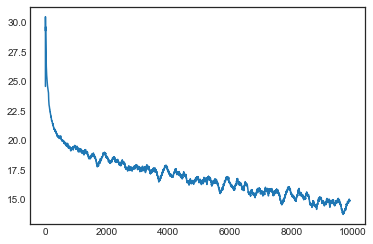

, but he was bressedis,
Mares, it my host:
Heth beeg your shatts blead was geveld, hear his eether petiness waw their pars, he's spard, your parits all me, than have Is, and I canny thep to thor is th


In [161]:
mod = LSTM_Model(vocab_size=62, hidden_size=256, learning_rate=0.1, sequence_length=25, layers=1)
character_generator = Character_generator('input.txt', mod)
character_generator.training_loop(10000)